In [1]:
import xgboost
import joblib
import numpy as np
from sklearn.metrics import accuracy_score
from quadratic_weighted_kappa import quadratic_weighted_kappa
import pandas as pd

In [2]:
#x = joblib.load('essay_ease10_sbert768_simbow_langerr_780')
x = joblib.load('essay_ease10_sbert768_simbow_langerr_780_normalized_asap7')
y = joblib.load("score_asap7")

In [4]:
x[0, :12]

array([4.97000000e+02, 9.90000000e+01, 4.00000000e+00, 1.42500000e+02,
       2.40000000e+01, 1.90000000e+01, 1.60000000e+01, 6.06060606e-02,
       5.30000000e+01, 5.42968094e-01, 2.51557647e-01, 4.82897384e-02])

In [3]:
x.shape

(1569, 780)

In [4]:
def get_feature_names_extended():
    ease_feats = ['Answer Length', 'Word Counts', 'Average Word Length', 'Good n-gram', 'Prompt Overlap',
              'Prompt Overlap (synonyms)', 'Punctuation Counts', 'Spelling Error', 'Unique Words', 'Prompt Similarity SBert']

    sbert_feats = []
    sbert_dim = 768

    for i in range(0, sbert_dim):
    	fname = "sbert_" + str(i) 
    	sbert_feats.append(fname)
    
    prompt_similarity_bow = ["Prompt Similarity BOW"]
    lang_error = ["Language Error"]
    
    feature_names = ease_feats + prompt_similarity_bow + lang_error + sbert_feats 

    print("len feature names: ", len(feature_names))
    
    return feature_names

feature_names = get_feature_names_extended()

len feature names:  780


In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(kf)

KFold(n_splits=5, random_state=42, shuffle=True)


In [6]:
model2 = xgboost.XGBRegressor(objective ='reg:squarederror',
                colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.03,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [13]:
qwk_scores = []

test_indices = []
pred_labels = []

for train_index, test_index in kf.split(x, y):
    
    X_train, X_test, Y_train, Y_test = x[train_index], x[test_index], y[train_index], y[test_index]
         
    model2.fit(X_train, Y_train)
    
    predict = model2.predict(X_test)    
    #predict = np.round(predict)
    
    pred_labels.extend(predict)
    test_indices.extend(test_index)

    result = quadratic_weighted_kappa(Y_test, predict)
    
    print("Qwk : ", result)
    
    qwk_scores.append(result)
    
    
np.mean(qwk_scores)

Qwk :  0.7868440454227331
Qwk :  0.7799846735247445
Qwk :  0.8032792484646124
Qwk :  0.780297657876947
Qwk :  0.7159836165874831


0.7732778483753041

In [8]:
print(len(pred_labels))
print(len(test_indices))

1569
1569


In [19]:
pred_labels_int = list(map(int, pred_labels))
print(pred_labels)
print(pred_labels_int)

[17.0, 15.0, 15.0, 19.0, 18.0, 10.0, 18.0, 20.0, 16.0, 19.0, 23.0, 12.0, 10.0, 21.0, 20.0, 13.0, 9.0, 20.0, 12.0, 18.0, 19.0, 19.0, 23.0, 15.0, 12.0, 16.0, 11.0, 14.0, 20.0, 19.0, 19.0, 12.0, 12.0, 16.0, 13.0, 10.0, 24.0, 15.0, 19.0, 19.0, 17.0, 15.0, 21.0, 20.0, 13.0, 15.0, 10.0, 18.0, 17.0, 13.0, 21.0, 16.0, 12.0, 13.0, 14.0, 20.0, 19.0, 18.0, 13.0, 16.0, 17.0, 14.0, 20.0, 17.0, 14.0, 16.0, 13.0, 18.0, 18.0, 19.0, 19.0, 12.0, 15.0, 18.0, 17.0, 15.0, 12.0, 16.0, 20.0, 16.0, 12.0, 16.0, 18.0, 14.0, 17.0, 15.0, 11.0, 16.0, 15.0, 11.0, 22.0, 20.0, 10.0, 24.0, 17.0, 15.0, 22.0, 11.0, 20.0, 12.0, 19.0, 19.0, 22.0, 17.0, 15.0, 15.0, 14.0, 15.0, 12.0, 16.0, 16.0, 14.0, 19.0, 19.0, 9.0, 13.0, 16.0, 20.0, 14.0, 21.0, 14.0, 15.0, 6.0, 17.0, 12.0, 13.0, 16.0, 19.0, 17.0, 23.0, 22.0, 11.0, 12.0, 8.0, 23.0, 21.0, 15.0, 15.0, 10.0, 14.0, 20.0, 16.0, 19.0, 13.0, 17.0, 14.0, 15.0, 13.0, 15.0, 15.0, 17.0, 24.0, 17.0, 18.0, 21.0, 11.0, 19.0, 22.0, 22.0, 13.0, 22.0, 14.0, 23.0, 14.0, 10.0, 16.0, 11.0, 1

In [14]:
new_score = np.zeros(1569)
new_score

array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
new_score[test_indices] = pred_labels_int

In [15]:
#new_score[test_indices] = pred_labels

In [16]:
new_score

array([10.57139969, 12.43374825, 14.37696648, ..., 16.12532616,
       20.86570549, 16.22631264])

In [17]:
new_score[60]

14.229757308959961

In [24]:
joblib.dump(new_score, 'score_model_normalized')

['score_model_normalized']

In [18]:
#joblib.dump(new_score, 'score_model_normalized_float')

['score_model_normalized_float']

## Create model

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape

(1255, 780)

In [9]:
d_train = xgboost.DMatrix(X_train, label=Y_train, feature_names=feature_names)
d_test = xgboost.DMatrix(X_test, label=Y_test, feature_names=feature_names)

In [18]:
model = xgboost.train({"learning_rate": 0.15, "max_depth":3}, d_train, 200, evals = [(d_test, "test")], early_stopping_rounds=20)

[0]	test-rmse:13.87827
Will train until test-rmse hasn't improved in 20 rounds.
[1]	test-rmse:11.91810
[2]	test-rmse:10.25118
[3]	test-rmse:8.85594
[4]	test-rmse:7.68045
[5]	test-rmse:6.71478
[6]	test-rmse:5.91181
[7]	test-rmse:5.25400
[8]	test-rmse:4.73006
[9]	test-rmse:4.31398
[10]	test-rmse:3.96823
[11]	test-rmse:3.69775
[12]	test-rmse:3.46285
[13]	test-rmse:3.29359
[14]	test-rmse:3.14961
[15]	test-rmse:3.04044
[16]	test-rmse:2.97394
[17]	test-rmse:2.91469
[18]	test-rmse:2.87060
[19]	test-rmse:2.84196
[20]	test-rmse:2.81294
[21]	test-rmse:2.77985
[22]	test-rmse:2.76479
[23]	test-rmse:2.74376
[24]	test-rmse:2.73083
[25]	test-rmse:2.71477
[26]	test-rmse:2.70767
[27]	test-rmse:2.69878
[28]	test-rmse:2.69048
[29]	test-rmse:2.67974
[30]	test-rmse:2.66775
[31]	test-rmse:2.66543
[32]	test-rmse:2.65752
[33]	test-rmse:2.65405
[34]	test-rmse:2.64175
[35]	test-rmse:2.63679
[36]	test-rmse:2.63128
[37]	test-rmse:2.63171
[38]	test-rmse:2.62531
[39]	test-rmse:2.62485
[40]	test-rmse:2.62014
[41]	te

In [19]:
yxgb_pred = model.predict(d_test)
yxgb_pred = np.round(yxgb_pred)

In [20]:
accuracy_score(yxgb_pred, Y_test)

0.16560509554140126

In [21]:
quadratic_weighted_kappa(yxgb_pred, Y_test)

0.7993881172654163

## Model Interpretation

In [22]:
imp_vals = model.get_fscore()
#print(imp_vals)
feature_important = model.get_score(importance_type='weight')
feats_sorted = sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
aa_25 = feats_sorted[:25]

In [23]:
x_axis = [i[0] for i in aa_25]
y_axis = [i[1] for i in aa_25]

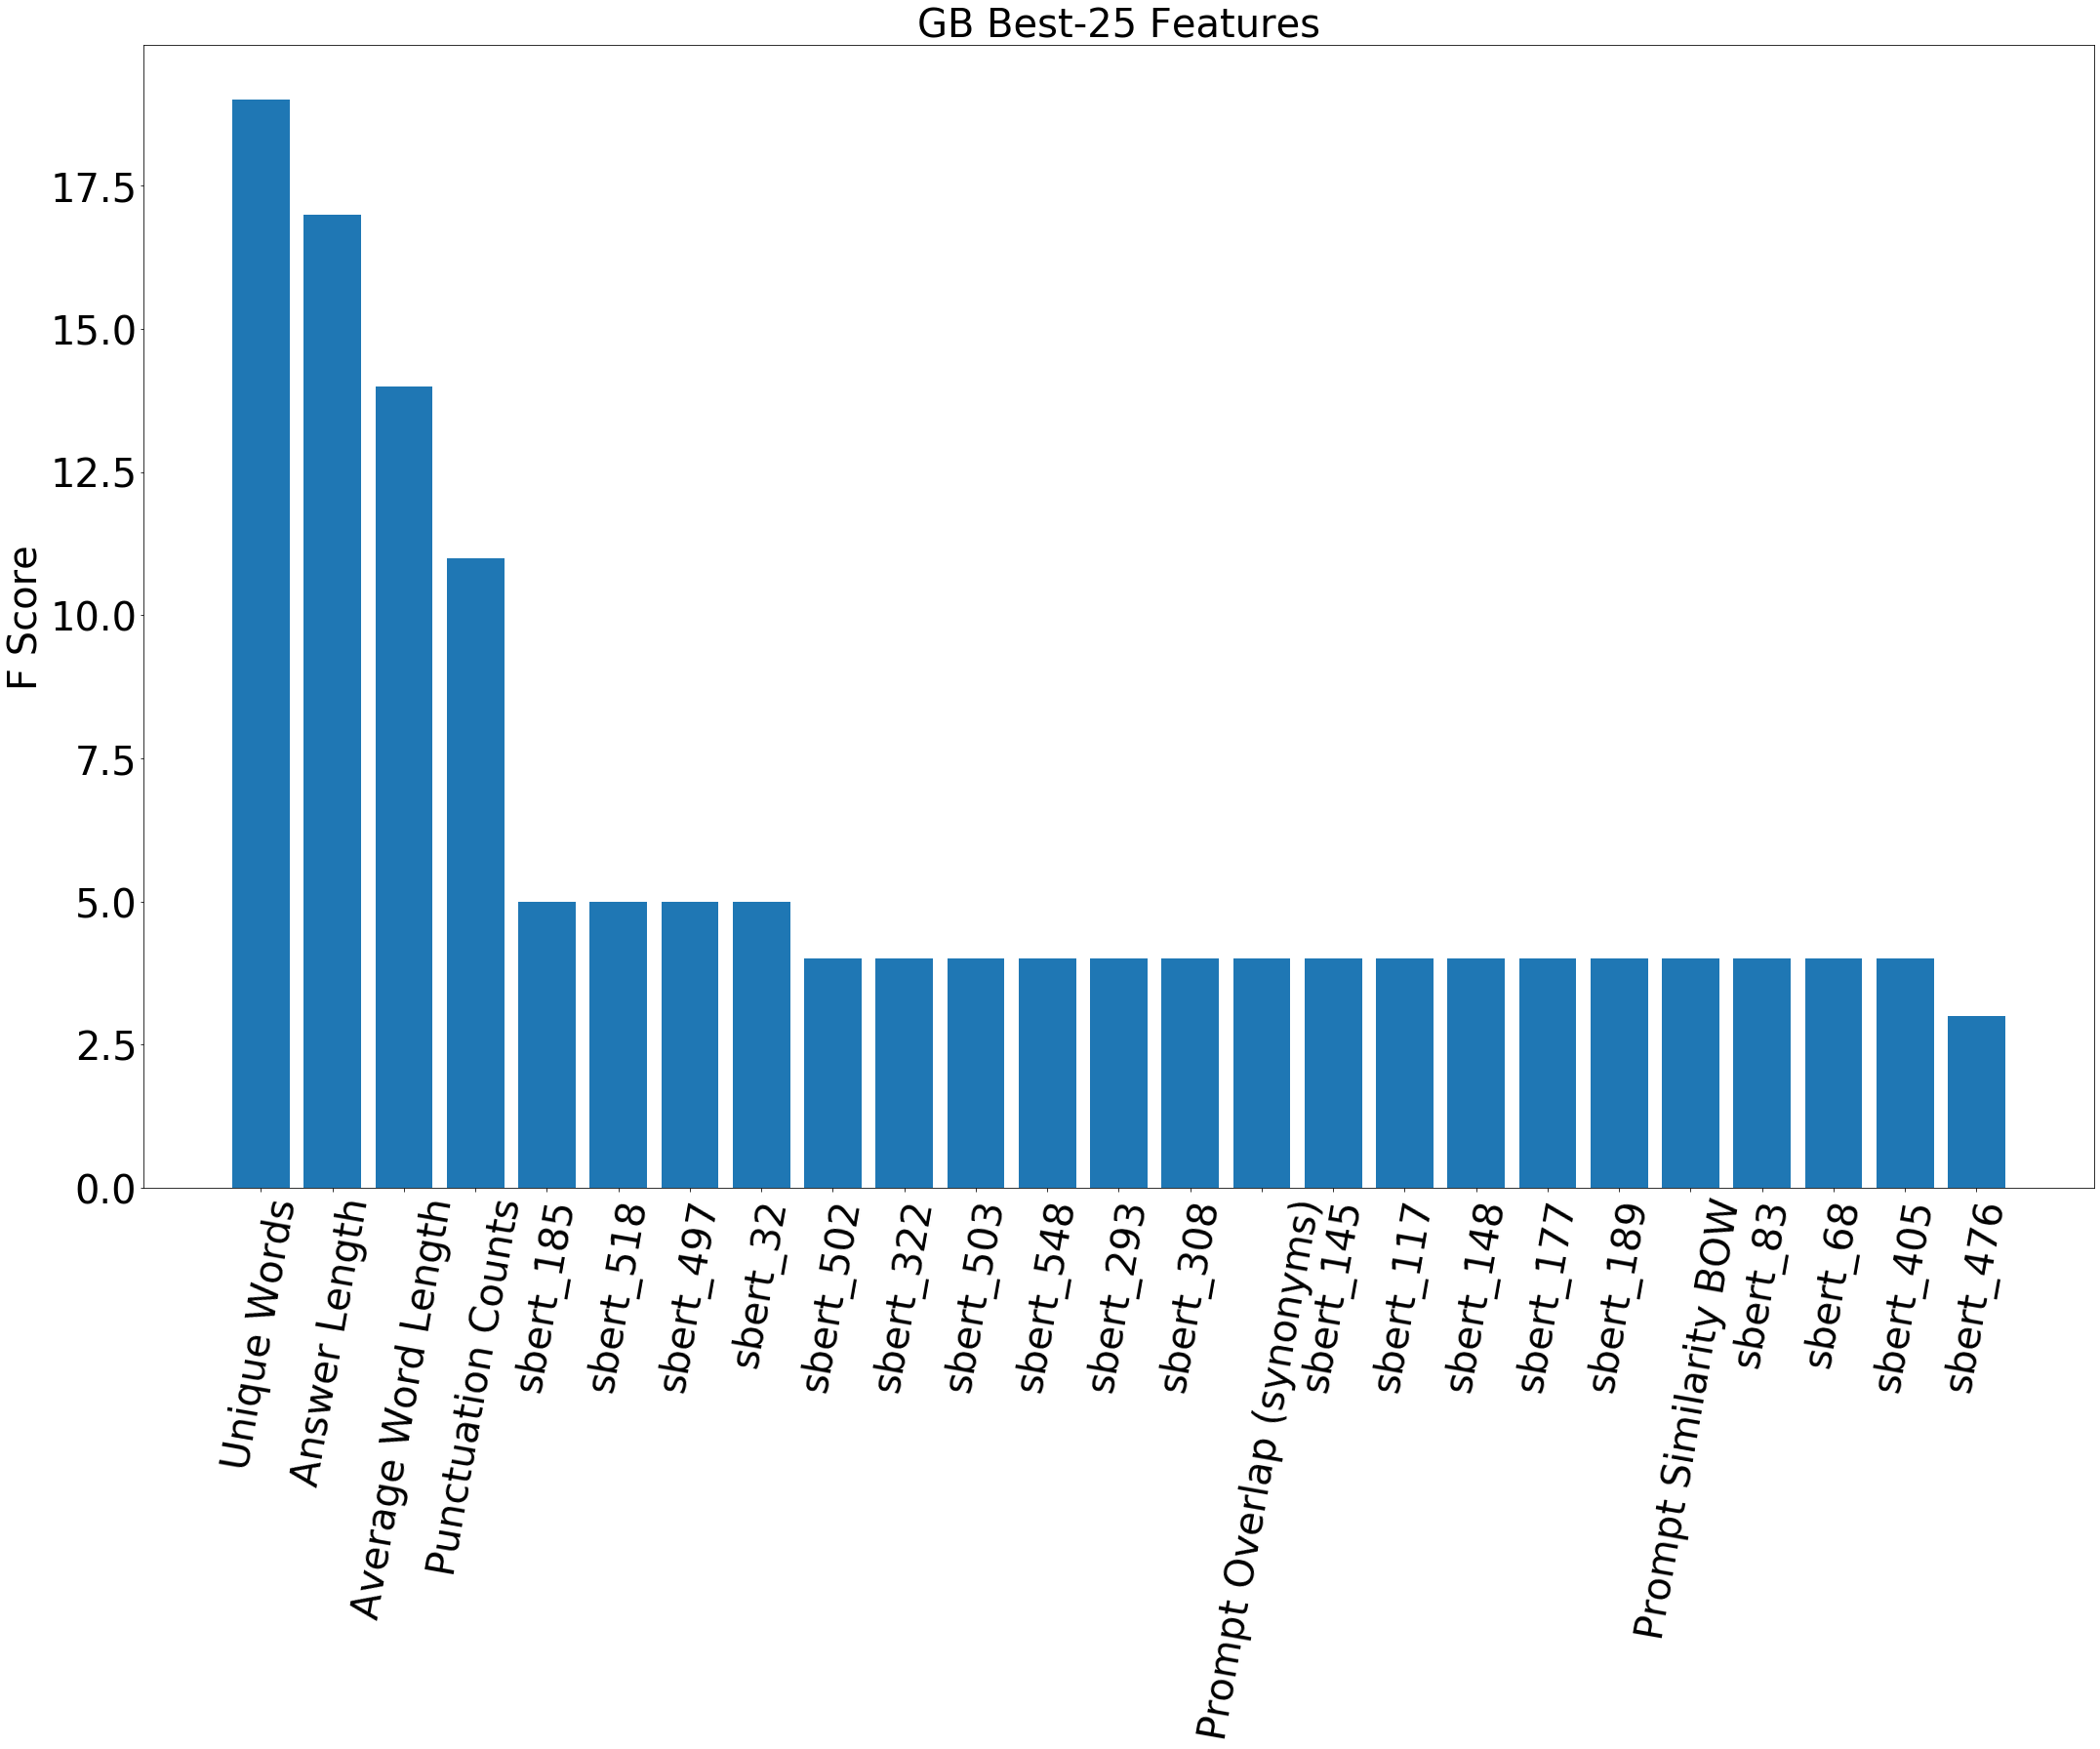

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,25))
plt.title("GB Best-25 Features", fontsize=40)
plt.bar(x_axis, y_axis, width=0.8, align='center')
plt.xticks(x_axis, fontsize=40, rotation=80)
plt.ylabel("F Score", fontsize=40)
plt.yticks(fontsize=40)
plt.tight_layout()
plt.savefig('gb_best_25.png')
plt.show()